In [29]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
os.chdir(r'/Users/joan/code/python/jokes-app')

In [2]:
import pandas as pd

In [3]:
import src.api.src.db.core as db
from src.api.src.db.secret import HOST_OVH, POSTGRES_USER, POSTGRES_PASSWORD_OVH, SCHEMA_NAME

In [4]:
conn = db.connect(host=HOST_OVH, user=POSTGRES_USER, password=POSTGRES_PASSWORD_OVH, schema_name=SCHEMA_NAME)

In [5]:
df = db.execute_read(conn, "select * from users_mail")

In [6]:
df_created = df.groupby([df["created_at"].dt.year, df["created_at"].dt.month, df["created_at"].dt.day]).count()

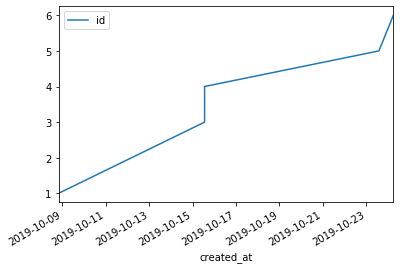

In [8]:
df.plot(x="created_at", y="id")

In [13]:
df_ratings = db.execute_read(conn, """select * from ratings where "source" = 'mail'""")

In [26]:
df_ratings.tail(10)

,id,user_id,joke_id,rating,created_at,source,day
7,174,348ce440-e9f4-11e9-bee9-784f43816789,164,7.5,2019-10-21 05:33:45.010631,mail,2019-10-21
8,175,cef6b0a6-ef4e-11e9-823c-0242ac150002,164,0.0,2019-10-21 05:51:06.842539,mail,2019-10-21
9,176,cef6b0a6-ef4e-11e9-823c-0242ac150002,25,0.0,2019-10-22 05:48:16.174837,mail,2019-10-22
10,177,348ce440-e9f4-11e9-bee9-784f43816789,25,10.0,2019-10-22 05:52:16.872670,mail,2019-10-22
11,178,348ce440-e9f4-11e9-bee9-784f43816789,221,7.5,2019-10-23 14:11:35.883494,mail,2019-10-23
12,180,adde0932-ef4e-11e9-823c-0242ac150002,221,2.5,2019-10-23 14:13:26.556646,mail,2019-10-23
13,182,cef6b0a6-ef4e-11e9-823c-0242ac150002,221,2.5,2019-10-24 05:58:49.763231,mail,2019-10-24
14,183,348ce440-e9f4-11e9-bee9-784f43816789,184,7.5,2019-10-24 06:43:05.099364,mail,2019-10-24
15,185,c1cca0a2-f624-11e9-ab26-0242ac1a0002,184,5.0,2019-10-24 07:12:38.975073,mail,2019-10-24
16,186,90ed9e40-f59e-11e9-ab26-0242ac1a0002,184,7.5,2019-10-24 07:50:39.012828,mail,2019-10-24


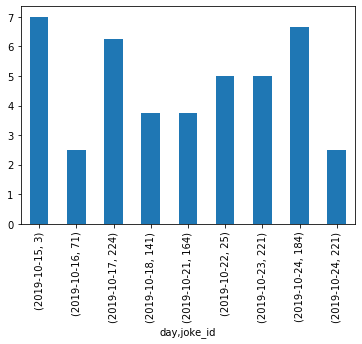

In [27]:
df_ratings["day"] = df_ratings["created_at"].dt.strftime('%Y-%m-%d')
df_ratings.groupby(["day", "joke_id"])["rating"].mean().plot.bar(x="day", y="rating")

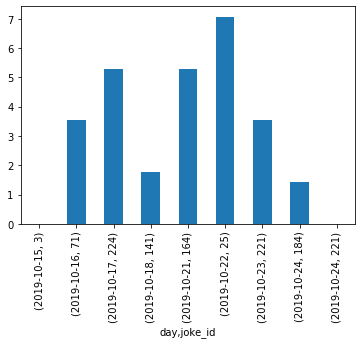

In [28]:
df_ratings.groupby(["day", "joke_id"])["rating"].std().plot.bar(x="day", y="rating")